In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from os import listdir
import warnings
from tqdm.notebook import tqdm
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Conv2D, Conv2DTranspose,
                                   MaxPooling2D, UpSampling2D, Reshape,
                                   Flatten, BatchNormalization, Dropout,
                                   LeakyReLU, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import array_to_img

import kagglehub
warnings.filterwarnings('ignore')

2025-07-17 15:03:53.415019: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752764633.635108      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752764633.699028      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [17]:
LATENT_DIM = 128  # Plus grand pour les images complexes
EPOCHS = 10
BATCH_SIZE = 32  # Plus petit pour les images 64x64
LEARNING_RATE = 0.001
IMG_SIZE = 64
CHANNELS = 3
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, CHANNELS)

In [18]:
print("📥 Téléchargement du dataset anime...")
splcher_animefacedataset_path = kagglehub.dataset_download('splcher/animefacedataset')
image_path = os.path.join(splcher_animefacedataset_path, 'images')
print(f"Dataset téléchargé: {image_path}")

📥 Téléchargement du dataset anime...
Dataset téléchargé: /kaggle/input/animefacedataset/images


In [8]:
def load_anime_images(path, image_size=(64, 64), max_images=10000):
    """Charge et préprocess les images anime"""
    print(f"🖼️ Chargement des images depuis {path}...")
    images = []
    
    for i, img_name in enumerate(tqdm(listdir(path))):
        if i >= max_images:
            break
            
        try:
            img_path = os.path.join(path, img_name)
            temp_image = Image.open(img_path)
            temp_image = temp_image.convert('RGB')
            image = temp_image.resize(image_size)
            image = np.asarray(image)
            # Normalisation entre [-1, 1]
            image = ((image - 127.5) / 127.5).astype("float32")
            images.append(image)
        except Exception as e:
            continue
    
    return np.asarray(images)
train_images = load_anime_images(image_path, (IMG_SIZE, IMG_SIZE))
print(f"📊 Images chargées: {train_images.shape}")

🖼️ Chargement des images depuis /kaggle/input/animefacedataset/images...


  0%|          | 0/63565 [00:00<?, ?it/s]

📊 Images chargées: (10000, 64, 64, 3)


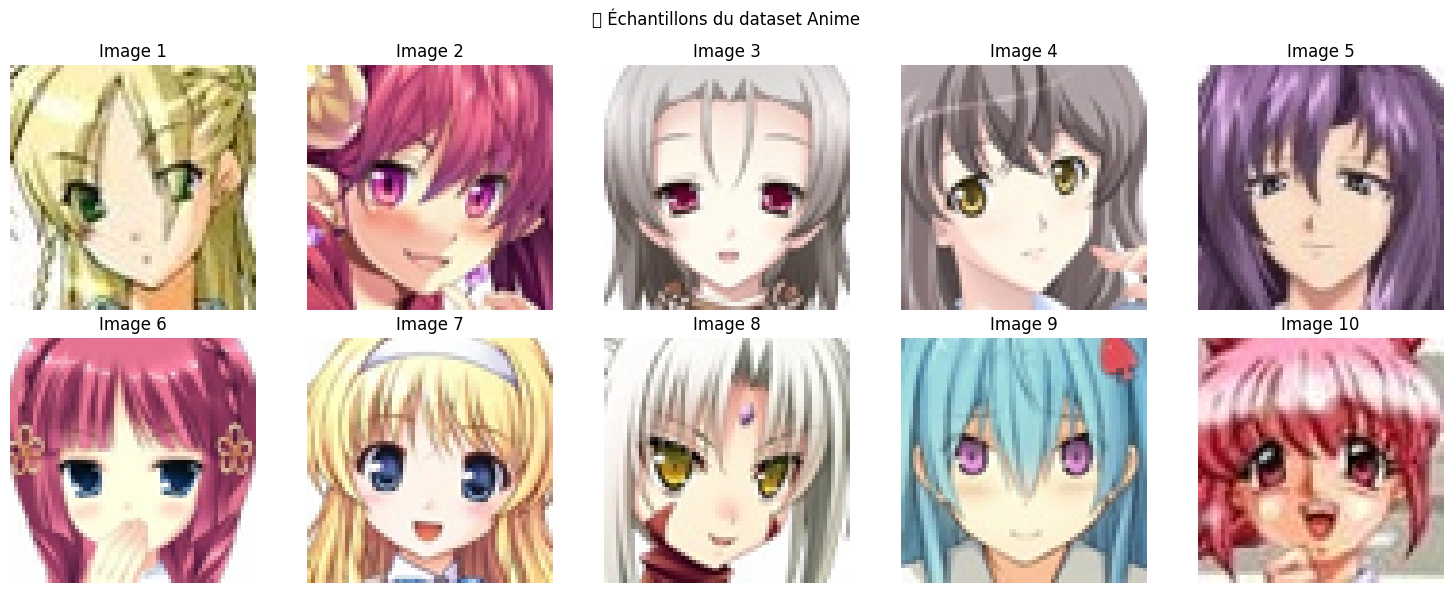

In [19]:
# Visualiser quelques exemples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    row, col = i // 5, i % 5
    # Dénormaliser pour l'affichage
    img_display = (train_images[i] * 127.5 + 127.5).astype(np.uint8)
    axes[row, col].imshow(img_display)
    axes[row, col].set_title(f'Image {i+1}')
    axes[row, col].axis('off')

plt.suptitle('🎨 Échantillons du dataset Anime')
plt.tight_layout()
plt.show()

In [20]:
def build_conv_encoder(input_shape=IMG_SHAPE, latent_dim=LATENT_DIM):
    """Encodeur convolutionnel pour images anime"""
    input_layer = Input(shape=input_shape, name='input')
    
    # Bloc 1: 64x64 -> 32x32
    x = Conv2D(64, (4, 4), strides=2, padding='same', name='enc_conv1')(input_layer)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization(name='enc_bn1')(x)
    
    # Bloc 2: 32x32 -> 16x16
    x = Conv2D(128, (4, 4), strides=2, padding='same', name='enc_conv2')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization(name='enc_bn2')(x)
    
    # Bloc 3: 16x16 -> 8x8
    x = Conv2D(256, (4, 4), strides=2, padding='same', name='enc_conv3')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization(name='enc_bn3')(x)
    
    # Bloc 4: 8x8 -> 4x4
    x = Conv2D(512, (4, 4), strides=2, padding='same', name='enc_conv4')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization(name='enc_bn4')(x)
    
    # Aplatir et créer l'espace latent
    x = Flatten(name='enc_flatten')(x)
    x = Dense(1024, name='enc_dense1')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization(name='enc_bn_dense')(x)
    x = Dropout(0.3, name='enc_dropout')(x)
    
    # Espace latent
    latent = Dense(latent_dim, activation='linear', name='latent')(x)
    
    encoder = Model(input_layer, latent, name='encoder')
    return encoder

def build_conv_decoder(latent_dim=LATENT_DIM, output_shape=IMG_SHAPE):
    latent_input = Input(shape=(latent_dim,), name='latent_input')
    
    # Dense layers pour reconstruire la forme
    x = Dense(1024, activation='relu', name='dec_dense1')(latent_input)
    x = BatchNormalization(name='dec_bn_dense1')(x)
    x = Dropout(0.3, name='dec_dropout1')(x)
    
    x = Dense(4 * 4 * 512, activation='relu', name='dec_dense2')(x)
    x = BatchNormalization(name='dec_bn_dense2')(x)
    x = Reshape((4, 4, 512), name='dec_reshape')(x)
    
    # Bloc 1: 4x4 -> 8x8
    x = Conv2DTranspose(256, (4, 4), strides=2, padding='same', name='dec_conv1')(x)
    x = BatchNormalization(name='dec_bn1')(x)
    x = LeakyReLU(0.2)(x)
    
    # Bloc 2: 8x8 -> 16x16
    x = Conv2DTranspose(128, (4, 4), strides=2, padding='same', name='dec_conv2')(x)
    x = BatchNormalization(name='dec_bn2')(x)
    x = LeakyReLU(0.2)(x)
    
    # Bloc 3: 16x16 -> 32x32
    x = Conv2DTranspose(64, (4, 4), strides=2, padding='same', name='dec_conv3')(x)
    x = BatchNormalization(name='dec_bn3')(x)
    x = LeakyReLU(0.2)(x)
    
    # Bloc 4: 32x32 -> 64x64
    x = Conv2DTranspose(CHANNELS, (4, 4), strides=2, padding='same', name='dec_conv4')(x)
    output = Activation('tanh', name='output')(x)
    
    decoder = Model(latent_input, output, name='decoder')
    return decoder

In [21]:
print("🏗️ Construction de l'encodeur...")
encoder = build_conv_encoder()
encoder.summary()

print("🏗️ Construction du décodeur...")
decoder = build_conv_decoder()
decoder.summary()

# Autoencodeur complet
print("🏗️ Construction de l'autoencodeur...")
input_layer = Input(shape=IMG_SHAPE)
encoded = encoder(input_layer)
decoded = decoder(encoded)
autoencoder = Model(input_layer, decoded, name='autoencoder')

# Compilation
autoencoder.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='mse',
    metrics=['mae']
)

🏗️ Construction de l'encodeur...


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv1 (Conv2D)              │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn1 (BatchNormalization)    │ (None, 32, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv2 (Conv2D)              │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn2 (BatchNormalization)    │ (None, 16, 16, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv3 (Conv2D)              │ (None, 8, 8, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn3 (BatchNormalization)    │ (None, 8, 8, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv4 (Conv2D)              │ (None, 4, 4, 512)      │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn4 (BatchNormalization)    │ (None, 4, 4, 512)      │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_flatten (Flatten)           │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense1 (Dense)              │ (None, 1024)           │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn_dense                    │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dropout (Dropout)           │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 128)            │       131,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,285,312 (43.05 MB)

 Trainable params: 11,281,344 (43.03 MB)

 Non-trainable params: 3,968 (15.50 KB)

🏗️ Construction du décodeur...


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ latent_input (InputLayer)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense1 (Dense)              │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn_dense1                   │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dropout1 (Dropout)          │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense2 (Dense)              │ (None, 8192)           │     8,396,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn_dense2                   │ (None, 8192)           │        32,768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_reshape (Reshape)           │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv1 (Conv2DTranspose)     │ (None, 8, 8, 256)      │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn1 (BatchNormalization)    │ (None, 8, 8, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv2 (Conv2DTranspose)     │ (None, 16, 16, 128)    │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn2 (BatchNormalization)    │ (None, 16, 16, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv3 (Conv2DTranspose)     │ (None, 32, 32, 64)     │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn3 (BatchNormalization)    │ (None, 32, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv4 (Conv2DTranspose)     │ (None, 64, 64, 3)      │         3,075 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Activation)             │ (None, 64, 64, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,323,587 (43.20 MB)

 Trainable params: 11,304,259 (43.12 MB)

 Non-trainable params: 19,328 (75.50 KB)

🏗️ Construction de l'autoencodeur...


In [13]:
autoencoder.summary()

# Callbacks pour l'entraînement
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
]

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 128)            │    11,285,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 64, 64, 3)      │    11,323,587 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,608,899 (86.25 MB)

 Trainable params: 22,585,603 (86.16 MB)

 Non-trainable params: 23,296 (91.00 KB)

In [22]:
# Séparation train/validation
split_idx = int(0.8 * len(train_images))
X_train = train_images[:split_idx]
X_val = train_images[split_idx:]

print(f"📊 Données d'entraînement: {X_train.shape}")
print(f"📊 Données de validation: {X_val.shape}")

📊 Données d'entraînement: (8000, 64, 64, 3)
📊 Données de validation: (2000, 64, 64, 3)


In [23]:
print("🚀 Début de l'entraînement...")
history = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

🚀 Début de l'entraînement...
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 225s 854ms/step - loss: 0.1849 - mae: 0.3301 - val_loss: 0.1162 - val_mae: 0.2580 - learning_rate: 0.0010
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 213s 852ms/step - loss: 0.1141 - mae: 0.2530 - val_loss: 0.1348 - val_mae: 0.2658 - learning_rate: 0.0010
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 214s 856ms/step - loss: 0.1048 - mae: 0.2407 - val_loss: 0.1207 - val_mae: 0.2507 - learning_rate: 0.0010
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 214s 857ms/step - loss: 0.1000 - mae: 0.2342 - val_loss: 0.1177 - val_mae: 0.2474 - learning_rate: 0.0010
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 214s 857ms/step - loss: 0.0957 - mae: 0.2286 - val_loss: 0.0968 - val_mae: 0.2217 - learning_rate: 0.0010
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 214s 855ms/step - loss: 0.0928 - mae: 0.2246 - val_loss: 0.0901 - val_mae: 0.2133 - learning_rate: 0.0010
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 212s 848ms/step - loss: 0.0886 - mae: 0.2185 - val_loss

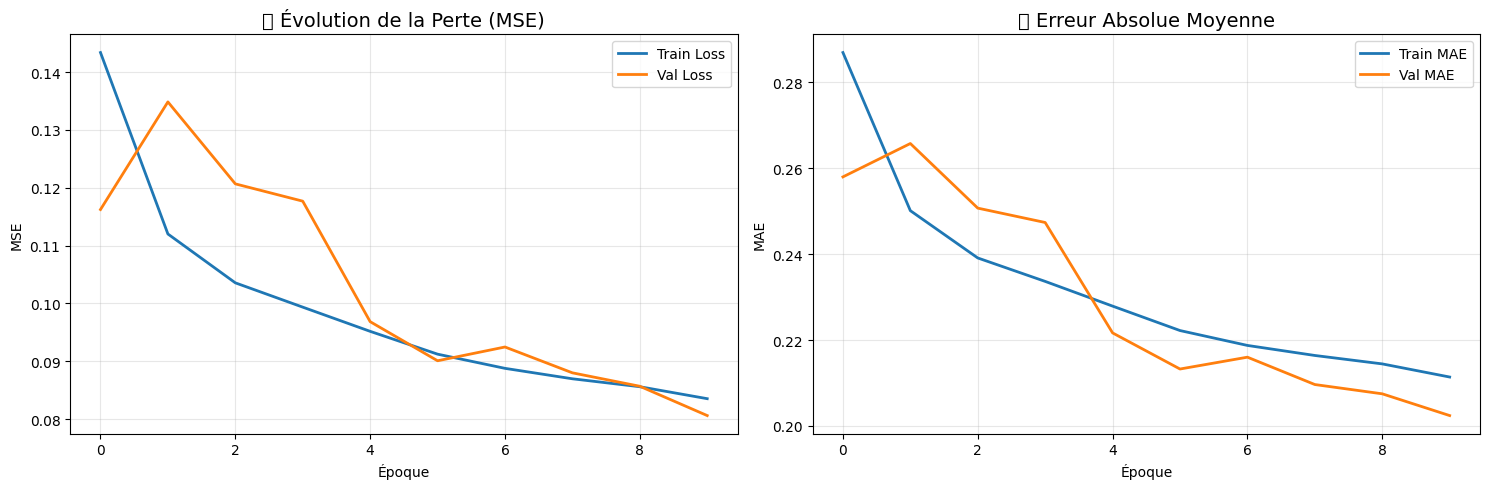

📊 Métriques finales:
   • Train Loss: 0.083529
   • Val Loss: 0.080610
🔄 Test de reconstruction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


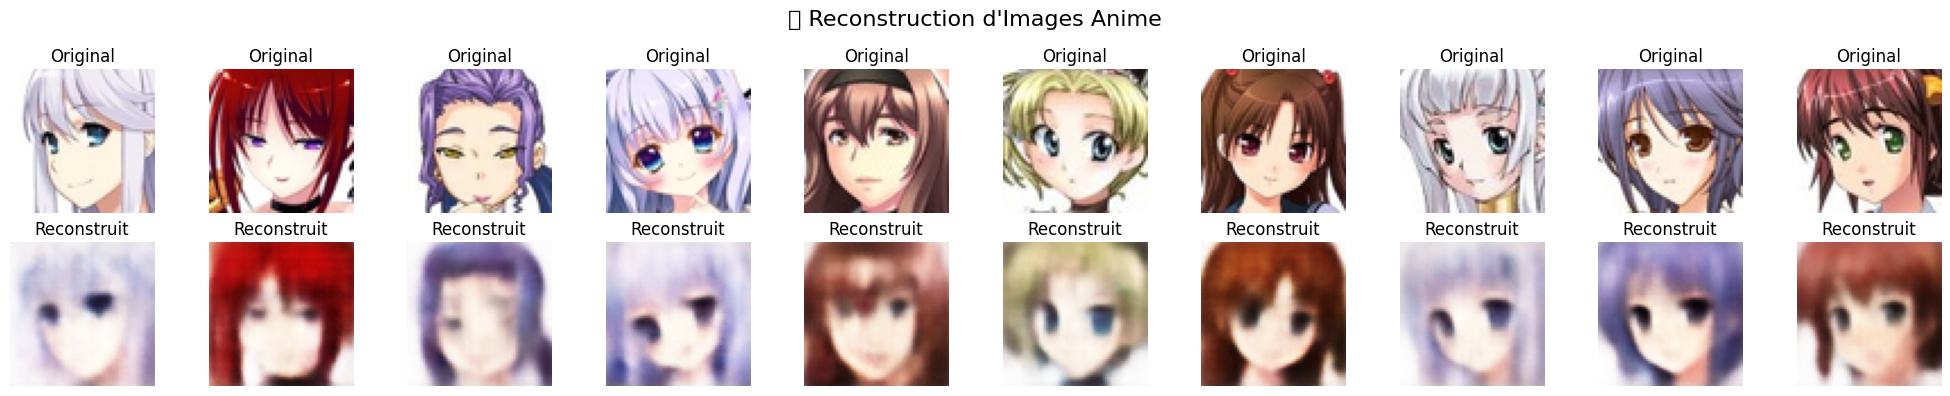

In [25]:
# Visualisation des courbes d'entraînement
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Perte
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('📉 Évolution de la Perte (MSE)', fontsize=14)
axes[0].set_xlabel('Époque')
axes[0].set_ylabel('MSE')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Val MAE', linewidth=2)
axes[1].set_title('📊 Erreur Absolue Moyenne', fontsize=14)
axes[1].set_xlabel('Époque')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Métriques finales
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"📊 Métriques finales:")
print(f"   • Train Loss: {final_train_loss:.6f}")
print(f"   • Val Loss: {final_val_loss:.6f}")

# Test de reconstruction
print("🔄 Test de reconstruction...")
X_test_sample = X_val[:10]
X_reconstructed = autoencoder.predict(X_test_sample)
# Visualisation des reconstructions
fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    # Image originale
    img_orig = (X_test_sample[i] * 127.5 + 127.5).astype(np.uint8)
    axes[0, i].imshow(img_orig)
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')
    
    # Image reconstruite
    img_recon = (X_reconstructed[i] * 127.5 + 127.5).astype(np.uint8)
    axes[1, i].imshow(img_recon)
    axes[1, i].set_title('Reconstruit')
    axes[1, i].axis('off')

plt.suptitle('🔄 Reconstruction d\'Images Anime', fontsize=16)
plt.tight_layout()
plt.show()

🎨 Génération d'images depuis l'espace latent...
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step
📊 Espace latent - Dimensions: (1000, 128)
📊 Moyenne: [-1.8173736  -0.13614146  0.8385875   2.899548   -1.174173  ]...
📊 Écart-type: [8.368946  8.153065  6.107673  6.4776087 6.493342 ]...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


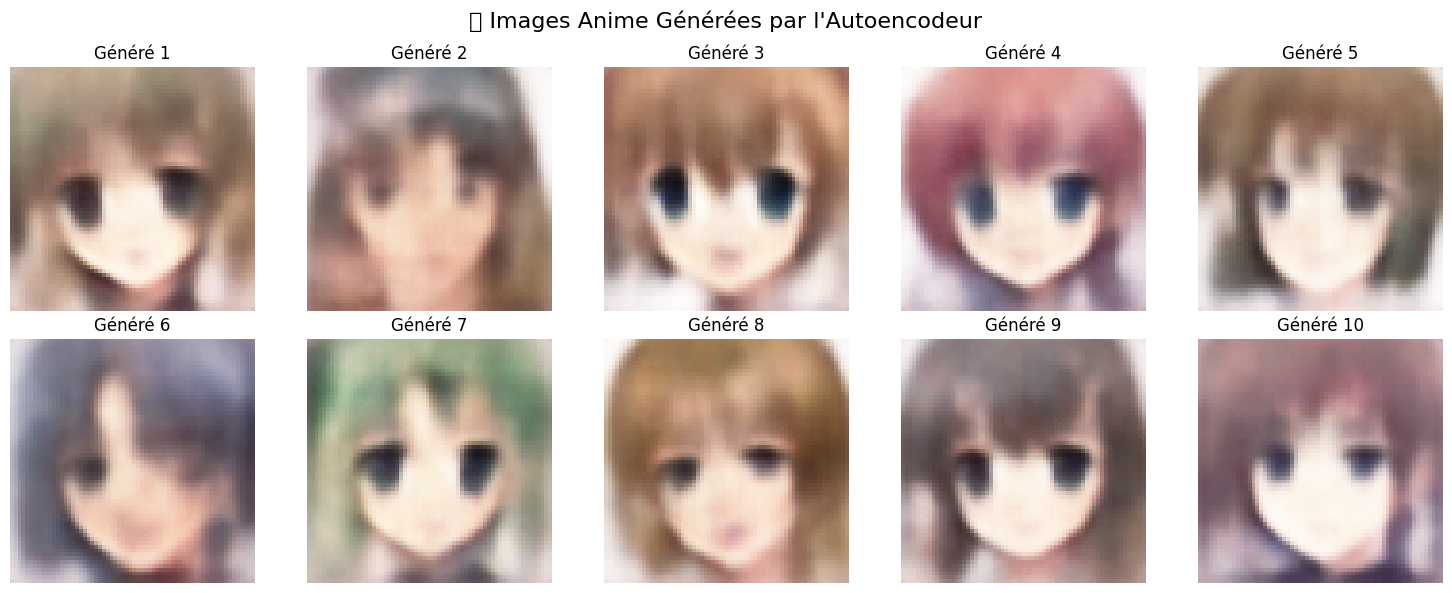

In [24]:
print("🎨 Génération d'images depuis l'espace latent...")

# Calculer les statistiques de l'espace latent
latent_representations = encoder.predict(X_val[:1000])
latent_mean = np.mean(latent_representations, axis=0)
latent_std = np.std(latent_representations, axis=0)

print(f"📊 Espace latent - Dimensions: {latent_representations.shape}")
print(f"📊 Moyenne: {latent_mean[:5]}...")  # Première 5 dimensions
print(f"📊 Écart-type: {latent_std[:5]}...")

# Générer des images aléatoirement
n_generated = 10
random_latents = np.random.normal(latent_mean, latent_std, size=(n_generated, LATENT_DIM))
generated_images = decoder.predict(random_latents)

# Visualiser les images générées
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(n_generated):
    row, col = i // 5, i % 5
    img_generated = (generated_images[i] * 127.5 + 127.5).astype(np.uint8)
    axes[row, col].imshow(img_generated)
    axes[row, col].set_title(f'Généré {i+1}')
    axes[row, col].axis('off')

plt.suptitle('🎨 Images Anime Générées par l\'Autoencodeur', fontsize=16)
plt.tight_layout()
plt.show()

🔄 Interpolation dans l'espace latent...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


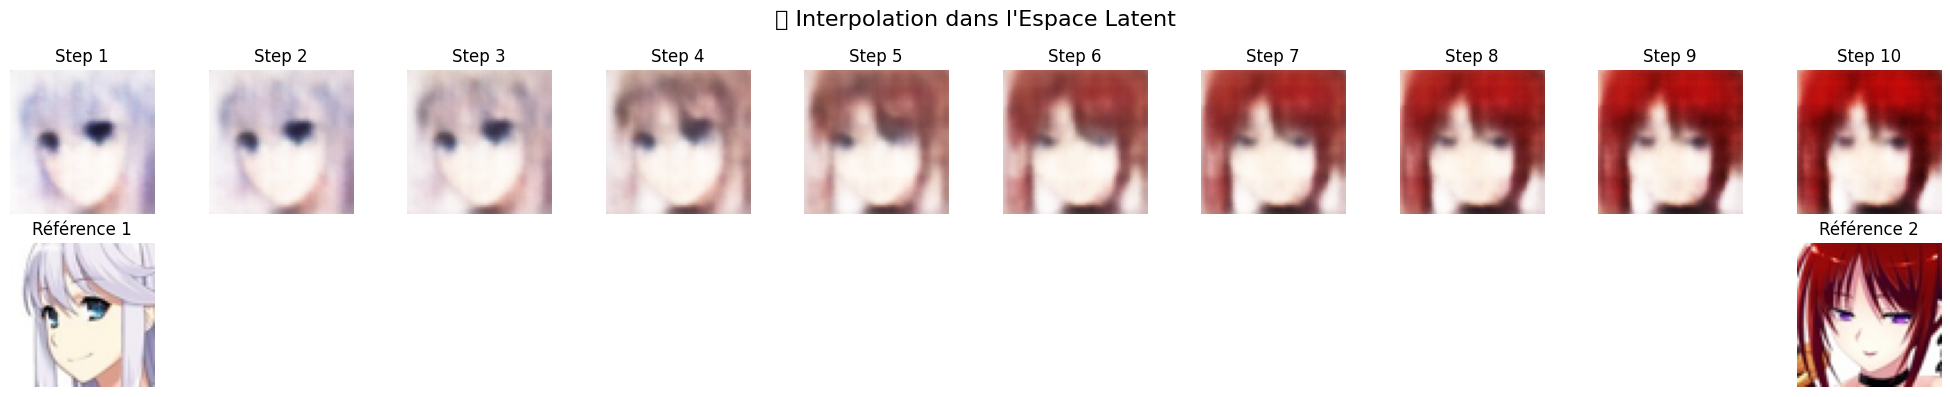

In [26]:
print("🔄 Interpolation dans l'espace latent...")
def interpolate_latent(point1, point2, n_steps=10):
    """Interpole entre deux points dans l'espace latent"""
    ratios = np.linspace(0, 1, n_steps)
    interpolated = []
    for ratio in ratios:
        interpolated.append(point1 * (1 - ratio) + point2 * ratio)
    return np.array(interpolated)

# Prendre deux images de référence
ref_images = X_val[:2]
ref_latents = encoder.predict(ref_images)

# Interpoler
interpolated_latents = interpolate_latent(ref_latents[0], ref_latents[1], n_steps=10)
interpolated_images = decoder.predict(interpolated_latents)

# Visualiser l'interpolation
fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    # Images interpolées
    img_interp = (interpolated_images[i] * 127.5 + 127.5).astype(np.uint8)
    axes[0, i].imshow(img_interp)
    axes[0, i].set_title(f'Step {i+1}')
    axes[0, i].axis('off')
    
    # Images de référence aux extrémités
    if i == 0:
        ref_img = (ref_images[0] * 127.5 + 127.5).astype(np.uint8)
        axes[1, i].imshow(ref_img)
        axes[1, i].set_title('Référence 1')
        axes[1, i].axis('off')
    elif i == 9:
        ref_img = (ref_images[1] * 127.5 + 127.5).astype(np.uint8)
        axes[1, i].imshow(ref_img)
        axes[1, i].set_title('Référence 2')
        axes[1, i].axis('off')
    else:
        axes[1, i].axis('off')

plt.suptitle('🔄 Interpolation dans l\'Espace Latent', fontsize=16)
plt.tight_layout()
plt.show()

In [31]:
def build_linear_encoder(input_shape=IMG_SHAPE, latent_dim=LATENT_DIM):
    """Encodeur linéaire pour images anime"""
    input_layer = Input(shape=input_shape, name='input')
    
    # Aplatir l'image d'entrée
    x = Flatten(name='enc_flatten')(input_layer)
    
    # Couches denses successives
    x = Dense(512, activation='linear', name='enc_dense1')(x)
    x = BatchNormalization(name='enc_bn1')(x)
    x = Dropout(0.3, name='enc_dropout1')(x)
    
    x = Dense(256, activation='linear', name='enc_dense2')(x)
    x = BatchNormalization(name='enc_bn2')(x)
    x = Dropout(0.3, name='enc_dropout2')(x)
    
    x = Dense(128, activation='linear', name='enc_dense3')(x)
    x = BatchNormalization(name='enc_bn3')(x)
    x = Dropout(0.3, name='enc_dropout3')(x)
    
    x = Dense(256, activation='linear', name='enc_dense4')(x)
    x = BatchNormalization(name='enc_bn4')(x)
    x = Dropout(0.3, name='enc_dropout4')(x)
    
    # Espace latent
    latent = Dense(latent_dim, activation='linear', name='latent')(x)
    
    encoder = Model(input_layer, latent, name='encoder')
    return encoder

def build_linear_decoder(latent_dim=LATENT_DIM, output_shape=IMG_SHAPE):
    """Décodeur linéaire pour images anime"""
    latent_input = Input(shape=(latent_dim,), name='latent_input')
    
    # Couches denses successives
    x = Dense(256, activation='linear', name='dec_dense1')(latent_input)
    x = BatchNormalization(name='dec_bn_dense1')(x)
    x = Dropout(0.3, name='dec_dropout1')(x)
    
    x = Dense(128, activation='linear', name='dec_dense2')(x)
    x = BatchNormalization(name='dec_bn_dense2')(x)
    x = Dropout(0.3, name='dec_dropout2')(x)
    
    x = Dense(256, activation='linear', name='dec_dense3')(x)
    x = BatchNormalization(name='dec_bn_dense3')(x)
    x = Dropout(0.3, name='dec_dropout3')(x)
    
    x = Dense(512, activation='linear', name='dec_dense4')(x)
    x = BatchNormalization(name='dec_bn_dense4')(x)
    x = Dropout(0.3, name='dec_dropout4')(x)
    
    # Couche de sortie pour reconstruire l'image
    output_size = output_shape[0] * output_shape[1] * output_shape[2]  # 64*64*3 = 12288
    x = Dense(output_size, activation='tanh', name='dec_output')(x)
    
    # Reshape pour retrouver la forme de l'image
    output = Reshape(output_shape, name='dec_reshape')(x)
    
    decoder = Model(latent_input, output, name='decoder')
    return decoder

In [32]:
print("🏗️ Construction de l'encodeur...")
encoder = build_linear_encoder()
encoder.summary()

print("🏗️ Construction du décodeur...")
decoder = build_linear_decoder()
decoder.summary()

# Autoencodeur complet
print("🏗️ Construction de l'autoencodeur...")
input_layer = Input(shape=IMG_SHAPE)
encoded = encoder(input_layer)
decoded = decoder(encoded)
autoencoder = Model(input_layer, decoded, name='autoencoder')

# Compilation
autoencoder.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='mse',
    metrics=['mae']
)

print("📊 Résumé de l'autoencodeur:")
autoencoder.summary()

# Callbacks pour l'entraînement
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
]

🏗️ Construction de l'encodeur...


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_flatten (Flatten)           │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense1 (Dense)              │ (None, 512)            │     6,291,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn1 (BatchNormalization)    │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dropout1 (Dropout)          │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense2 (Dense)              │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn2 (BatchNormalization)    │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dropout2 (Dropout)          │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense3 (Dense)              │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn3 (BatchNormalization)    │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dropout3 (Dropout)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense4 (Dense)              │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn4 (BatchNormalization)    │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dropout4 (Dropout)          │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,526,720 (24.90 MB)

 Trainable params: 6,524,416 (24.89 MB)

 Non-trainable params: 2,304 (9.00 KB)

🏗️ Construction du décodeur...


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ latent_input (InputLayer)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense1 (Dense)              │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn_dense1                   │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dropout1 (Dropout)          │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense2 (Dense)              │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn_dense2                   │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dropout2 (Dropout)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense3 (Dense)              │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn_dense3                   │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dropout3 (Dropout)          │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense4 (Dense)              │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn_dense4                   │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dropout4 (Dropout)          │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_output (Dense)              │ (None, 12288)          │     6,303,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_reshape (Reshape)           │ (None, 64, 64, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,538,880 (24.94 MB)

 Trainable params: 6,536,576 (24.94 MB)

 Non-trainable params: 2,304 (9.00 KB)

🏗️ Construction de l'autoencodeur...
📊 Résumé de l'autoencodeur:


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 128)            │     6,526,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 64, 64, 3)      │     6,538,880 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,065,600 (49.84 MB)

 Trainable params: 13,060,992 (49.82 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [33]:
# Callbacks pour l'entraînement
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
]

# Séparation train/validation
split_idx = int(0.8 * len(train_images))
X_train = train_images[:split_idx]
X_val = train_images[split_idx:]

print(f"📊 Données d'entraînement: {X_train.shape}")
print(f"📊 Données de validation: {X_val.shape}")

# Entraînement
print("🚀 Début de l'entraînement...")
history = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

📊 Données d'entraînement: (8000, 64, 64, 3)
📊 Données de validation: (2000, 64, 64, 3)
🚀 Début de l'entraînement...
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 110ms/step - loss: 0.2759 - mae: 0.4173 - val_loss: 0.2056 - val_mae: 0.3344 - learning_rate: 0.0010
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 109ms/step - loss: 0.1692 - mae: 0.3136 - val_loss: 0.1561 - val_mae: 0.2926 - learning_rate: 0.0010
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 109ms/step - loss: 0.1631 - mae: 0.3078 - val_loss: 0.1493 - val_mae: 0.2871 - learning_rate: 0.0010
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - loss: 0.1613 - mae: 0.3064 - val_loss: 0.1500 - val_mae: 0.2884 - learning_rate: 0.0010
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 110ms/step - loss: 0.1581 - mae: 0.3033 - val_loss: 0.1456 - val_mae: 0.2841 - learning_rate: 0.0010
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 109ms/step - loss: 0.1562 - mae: 0.3015 - val_loss: 0.1430 - val_mae: 0.2828 - learning_rate: 0.0010
Epoch 7/10
250

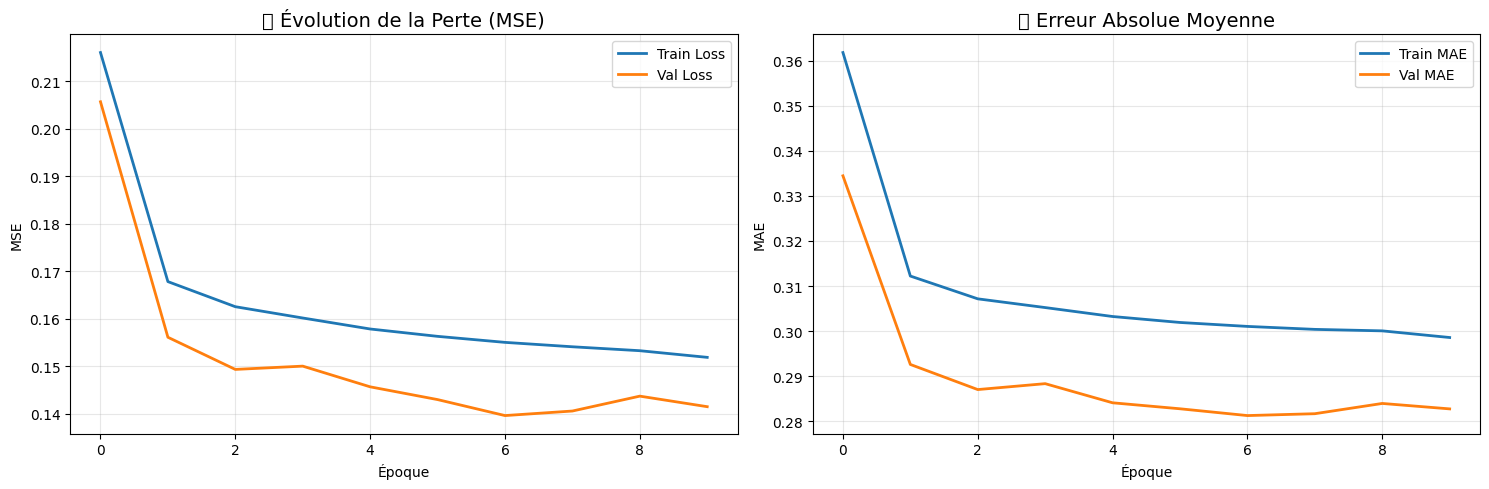

📊 Métriques finales:
   • Train Loss: 0.151841
   • Val Loss: 0.141457


In [34]:
# Visualisation des courbes d'entraînement
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Perte
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('📉 Évolution de la Perte (MSE)', fontsize=14)
axes[0].set_xlabel('Époque')
axes[0].set_ylabel('MSE')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Val MAE', linewidth=2)
axes[1].set_title('📊 Erreur Absolue Moyenne', fontsize=14)
axes[1].set_xlabel('Époque')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Métriques finales
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"📊 Métriques finales:")
print(f"   • Train Loss: {final_train_loss:.6f}")
print(f"   • Val Loss: {final_val_loss:.6f}")


🔄 Test de reconstruction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


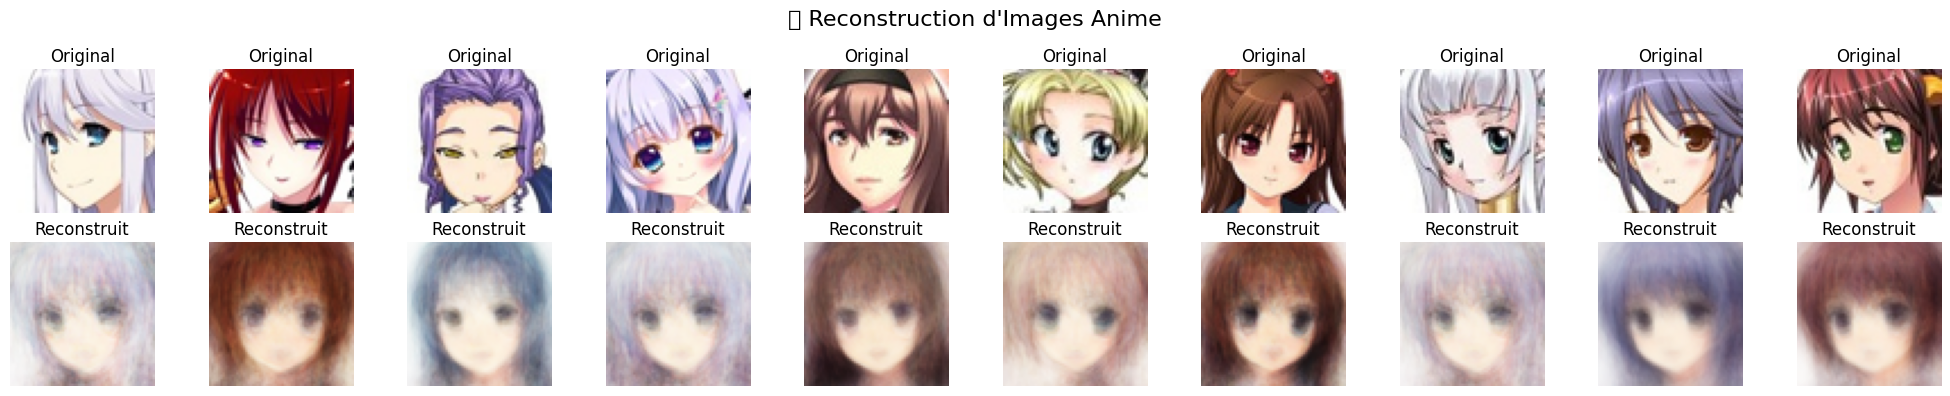

In [35]:
print("🔄 Test de reconstruction...")
X_test_sample = X_val[:10]
X_reconstructed = autoencoder.predict(X_test_sample)

# Visualisation des reconstructions
fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    # Image originale
    img_orig = (X_test_sample[i] * 127.5 + 127.5).astype(np.uint8)
    axes[0, i].imshow(img_orig)
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')
    
    # Image reconstruite
    img_recon = (X_reconstructed[i] * 127.5 + 127.5).astype(np.uint8)
    axes[1, i].imshow(img_recon)
    axes[1, i].set_title('Reconstruit')
    axes[1, i].axis('off')

plt.suptitle('🔄 Reconstruction d\'Images Anime', fontsize=16)
plt.tight_layout()
plt.show()

🎨 Génération d'images depuis l'espace latent...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


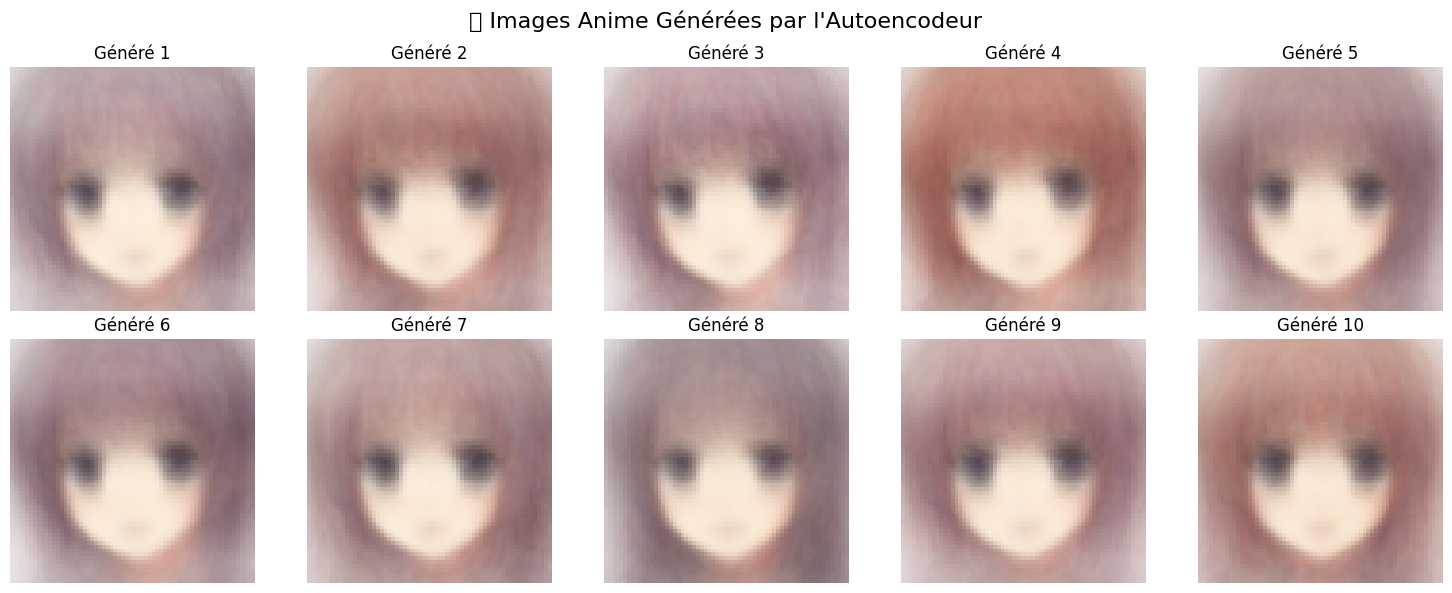

In [37]:
print("🎨 Génération d'images depuis l'espace latent...")

# Calculer les statistiques de l'espace latent
latent_representations = encoder.predict(X_val[:1000])
latent_mean = np.mean(latent_representations, axis=0)
latent_std = np.std(latent_representations, axis=0)


# Générer des images aléatoirement
n_generated = 10
random_latents = np.random.normal(latent_mean, latent_std, size=(n_generated, LATENT_DIM))
generated_images = decoder.predict(random_latents)

# Visualiser les images générées
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(n_generated):
    row, col = i // 5, i % 5
    img_generated = (generated_images[i] * 127.5 + 127.5).astype(np.uint8)
    axes[row, col].imshow(img_generated)
    axes[row, col].set_title(f'Généré {i+1}')
    axes[row, col].axis('off')

plt.suptitle('🎨 Images Anime Générées par l\'Autoencodeur', fontsize=16)
plt.tight_layout()
plt.show()
